## Crop segmentation and vegtation index monitoring for repeat monitoring
----------------------

The following workflow demonstrates image segmentation and property attribution techniques using open source python libs employed on an agricultural research site run by IBERS, Aberystwyth University. All imagery was collected and is owned by IBERS, who are happy to for it and the methods to be used for this demonstration of how UAV imagery can be analysed in an agricultural context.     

The aim is to automatically segment each crop plot and record it's state via spectral and morphological properties. The outcome is achieved using classical image processing techniques implemented widely. 
The components are explained in detail first for educational purposes to give an insight into the process. The basic functions are implemented in the library Geospatial-learn implemented by the author. 

This dataset is an RGB ortho-mosaic, DSM and point-cloud collected using a quad-copter platform.

The workflow is representative of that which would be applied in agriculture

**Dependencies:**

The python libraries scikit-image and shapely will be used for image processing as well as numpy for basic array handling. 

The library geospatial-learn (Ciaran Robb), is used to attribute the segments with statistics based on the point cloud and underlying image values  Please ensure this is installed as per the instruction on the github site.

https://github.com/Ciaran1981/geospatial-learn

Whilst matplotlib will be used to visualise some results in this notebook, QGIS 3 offers a more versatile platform for this purpose for the final datasets, so please ensure this is installed. Once installed, install the HCMGIS plugin to use various web-based base-layers for visualisation purposes. 

**Assumed knowledge:**

Basic GIS, basic image processing, remote sensing, python and command line use. For people who are intermediate > expert in this field much of this will be very familiar. Most algorithms here date to 1980s and previous!

Remember to query function args open a new cell (the plus icon) and write the function with a question mark - i.e

```python 
zonal_rgb_idx?
```
The lines of code have been written with readability in mind making each step as clear as possible (I hope), hence they are obviously not the briefest/most efficient way of doing things!

**Data**

The data is temporarily found in this google drive folder until QinetiQ find somewhere to store it.

https://drive.google.com/open?id=1eM5pwMMwLSzp7S3fr-NJr6pzDi3tD0n3

The file required is **Cropseg.zip** - extract this somewhere appropriate and change dir to this folder.

This contains: 

- clipped.tif (the main image of a field of oat crops
- horzflip.tif (a template image)
- vert.tif (ditto)


In [1]:
%matplotlib inline

## Part 1
### Image processing
**This notebook includes a lot of module imports! I have categorised them a bit so their use is clearer**.

Please refer to the lib APIs for more details.

In [2]:
# The usual suspects
from matplotlib import pyplot as plt
import numpy as np

#scikit-image
 # general image utils
from skimage import io
from skimage.color import rgb2gray
from skimage import exposure
from skimage.util import img_as_ubyte
# skimage-based image filtering, feature detection & analysis
import skimage.morphology as skm # eg binary_closing, square, disk, diameter_closing,  area_opening
from skimage.filters import threshold_otsu
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import match_template, canny
from skimage.draw import line, line_aa

# shapely for geometry manipulation
from shapely.geometry import Polygon, box, LineString


In [ ]:
# Change to your own dir
cd my/path/to/Cropseg

### Input imagery

We read in the input imagery and covert it to grayscale using the nested commands below.

The image is converted to greyscale make it useable for the various image processing routines used.
 

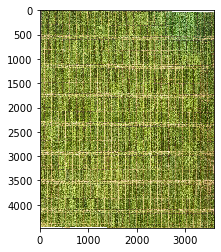

In [3]:
gray = rgb2gray(io.imread('clipped.tif'))

imeq = exposure.equalize_hist(img_as_ubyte(gray))
rgb = io.imread('clipped.tif')

plt.imshow(rgb)

del rgb

### Template matching and filtering

Given the relatively uniform pattern of crop plots, one potential method of deriving the features required is a template matching filter will accenuate pixel values between the plots.

Hence we load a template of this cropped from the image using GIMP software. 

The template is a horizontal section between the plots. We pass this horzontally then rotate it 90 degrees and pass it vertically to produce corresponding 'membership images from which we will threshold lines. 

The aim here is to produce an image with higher contrast at the boundaries as these areas are most highly correlated with the template. Whilst there are other generalised filtering/edge detection techinques, this method provides a solution, tailored specifically to the features in the image. 

**Cleaner line detection results are achieved through separate filtering of the two planes**


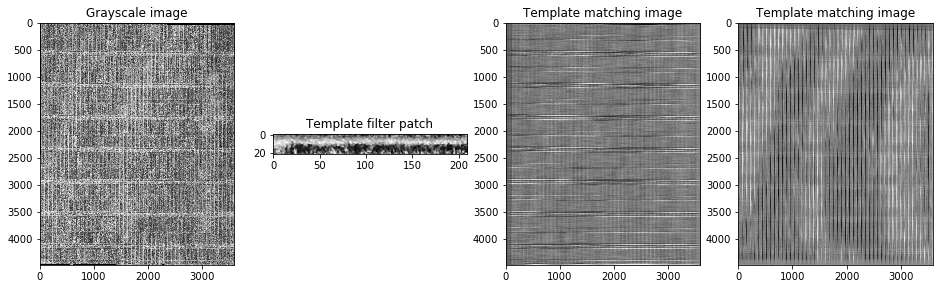

In [4]:
htemplate = rgb2gray(io.imread('horzflip.tif'))

vtemplate = rgb2gray(io.imread('vert.tif'))

# template matching
vresult = match_template(gray, vtemplate, pad_input=True)

hresult = match_template(gray, htemplate, pad_input=True)

fig, axes = plt.subplots(1, 4, figsize=(16,16))
plt.title("Original image") 
axes[0].imshow(gray, cmap="gray") 
axes[0].set_title("Grayscale image") 
axes[1].imshow(htemplate, cmap="gray") 
axes[1].set_title("Template filter patch") 
axes[2].set_title("Template matching image") 
axes[2].imshow(hresult, cmap="gray") 
axes[3].set_title("Template matching image") 
axes[3].imshow(vresult, cmap="gray")
plt.show()

### Thresholding to binary and image morphology

Now we use Otsu's method to automatically threshold the template matched image. The method seeks to separate the image into classes by minimising intra-class variance, producing an image of foreground and background.

Some morphological filtering follows to eliminate atrifacts in the result. We use a long thin structuring element (or moving window), as this will favour closing gaps along the horizontal axis and the vertical equivelant for vertical lines. 

The lack of detail in the results is down to the limitations of matplotlib with a large image!

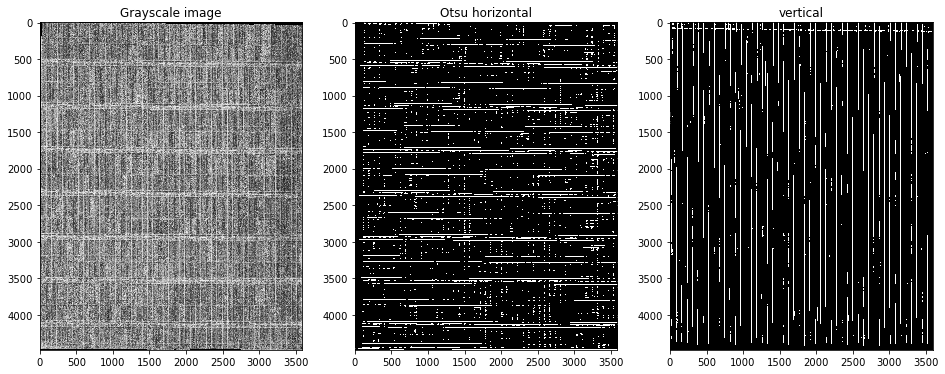

In [5]:
# Obtain the DN threshold
vthresh = threshold_otsu(vresult)


hthresh = threshold_otsu(hresult)

# apply it to binarise the image
vbw = vresult > vthresh
#inversion for vertical
vbw = np.invert(vbw)

hbw = hresult > hthresh

# The structuring elements
selemh = skm.rectangle(2, 12)

selemv = skm.rectangle(12, 12)

# morphological closing
hclosed = skm.binary_closing(hbw, selemh)

vclosed = skm.binary_closing(vbw, selemv)

fig, axes = plt.subplots(1, 3, figsize=(16,16))
plt.title("Original image") 
axes[0].set_title("Grayscale image") 
axes[0].imshow(gray, cmap="gray") 
axes[1].set_title("Otsu horizontal") 
axes[1].imshow(hclosed, cmap="gray") 
axes[2].set_title("vertical") 
axes[2].imshow(vclosed, cmap="gray") 
plt.show()

### Other potential methods

Whilst the use of template filtering appears effective, it does depend on creating one every time and may start come unstuck (i.e noisier) when orientations are less near 90 degree increments. 

Similar results to the above can be achieved using edge detection techniques. A notable example would be Canny edge detection. This is ultimately down to the data provided, conditions, noise etc, but has the advantage of only producing one input image for line detection.

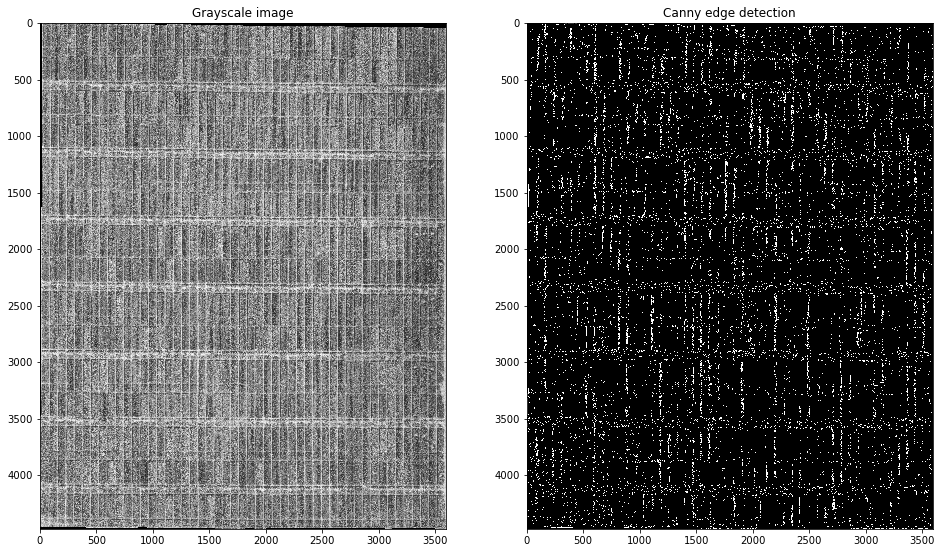

In [6]:
edgeCny = canny(gray, sigma=3)

fig, axes = plt.subplots(1, 2, figsize=(16,16))

plt.title("Original image") 
axes[0].set_title("Grayscale image") 
axes[0].imshow(gray, cmap="gray") 
axes[1].set_title("Canny edge detection") 
axes[1].imshow(edgeCny, cmap="gray") 
plt.show()

### Hough tranform, corner and line detection

The hough transform seeks to identify lines in imagery using geometry and a pixel accumulator to "score" potential lines and works on the principal that planar shapes can be represented in mathematical form. 

A line is included in the output if it exceeds a certain number of votes, which can be specified by the user. Each line is represented by the intersection of sinusodial waves in a hough space, so the intersections with most votes as specified are considered valid.  

A good basic description is available here:

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

A good demonstration is also here, which is near-identical to the one below.

https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html

The following calculates the hough tranform and plots the detected lines over the original image. This uses the 'classic' hough method where the lines are continuous across the image. 

We will stick with the otsu-based inputs for now, but the canny edge could easily be used.


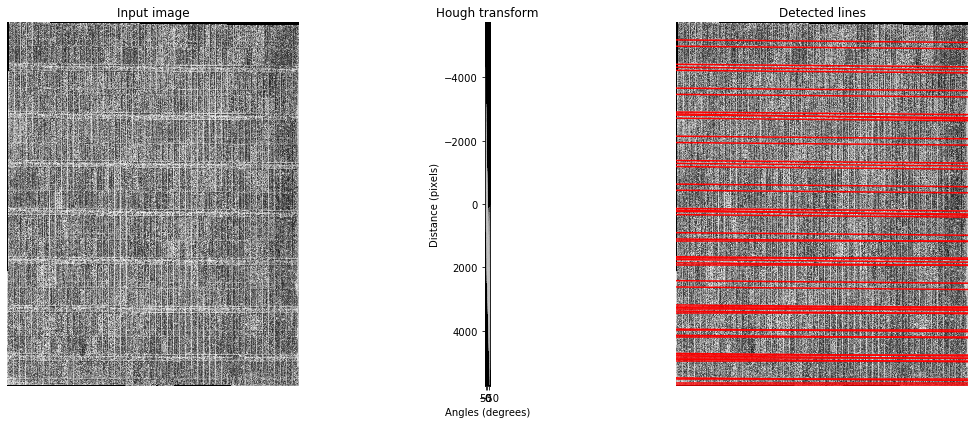

In [7]:
# make array of angles to test - skimage requires at least 10 incidentally
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)

# horizontal detection
hh, htheta, hd = hough_line(hclosed, theta=tested_angles)

#plot prep
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(gray, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

#the hough space plot
ax[1].imshow(np.log(1 + hh),
             extent=[np.rad2deg(htheta[-1]), np.rad2deg(htheta[0]), hd[-1], hd[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_ylabel('Distance (pixels)')
ax[1].set_xlabel('Angles (degrees)')
ax[1].axis('image')

# the image with superimposed lines
ax[2].imshow(gray, cmap='gray')
origin = np.array((0, gray.shape[1]))

# loop to plot each line
for _, angle, dist in zip(*hough_line_peaks(hh, htheta, hd)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')

# tidyup
ax[2].set_xlim(origin)
ax[2].set_ylim((gray.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

As we can see from the output, we have done a pretty good job of demaracating the horizontal plot boundaries. Now for the vertical....

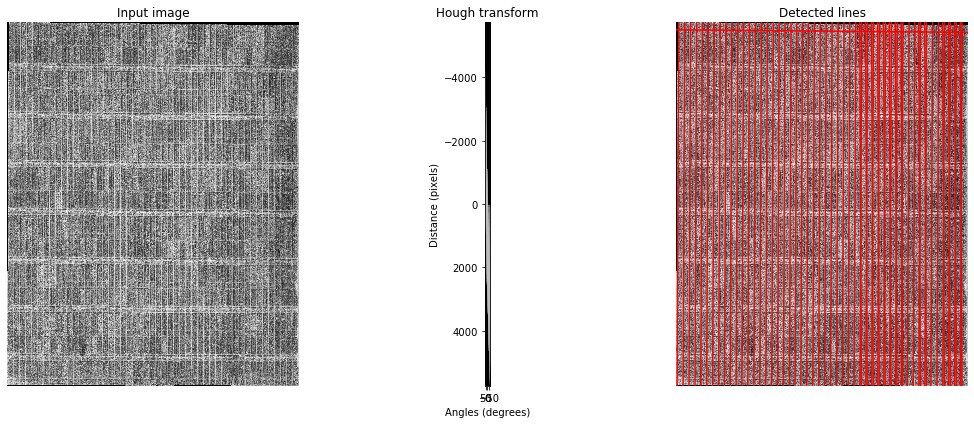

In [12]:
# vertical detection
vh, vtheta, vd = hough_line(vclosed, theta=tested_angles)

#set up the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(gray, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

#the hough space plot
ax[1].imshow(np.log(1 + vh),
             extent=[np.rad2deg(vtheta[-1]), np.rad2deg(vtheta[0]), vd[-1], vd[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_ylabel('Distance (pixels)')
ax[1].set_xlabel('Angles (degrees)')
ax[1].axis('image')

# the image with superimposed lines
ax[2].imshow(gray, cmap='gray')
origin = np.array((0, gray.shape[1]))

# loop to plot each line
for _, angle, dist in zip(*hough_line_peaks(vh, vtheta, vd)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')

# tidyup   
ax[2].set_xlim(origin)
ax[2].set_ylim((gray.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')
plt.tight_layout()
plt.show()


### Digitising lines to array, inversion to segments & conversion to geo-refrenced image

Here we use a similar loop to those above but this time calculate the intersection of the line with the image.

The lines are only defined by angle and entry point, hence the extrema are beyond the image coordinate system of the image (positively or negatively).

Hence, we must constrain them to where they intersect the image extent to write them to an array the same size as the original image. The shapely library is used for this purpose, which is a python wrapper of the GEOS library. Shapely is rather useful during de-bugging as you can view the shapely geometry object in the ipython interpreter (amongst other things).  

Finally we invert the image so positve values are the crop plots rather than the boundaries.


In [13]:

#Array to write the lines to
empty = np.zeros_like(gray, dtype=np.bool)

# dimensions for indexing
height, width = empty.shape

# geometry representing the image/array extent
bbox = box(width, height, 0, 0)

# main loop to write lines
for _, angle, dist in zip(*hough_line_peaks(hh, htheta, hd)):
    
    # here we obtain y extrema in our arbitrary coord system
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    
    # shapely used to get the geom and intersection in our arbitrary
    # coordinate system
    linestr = LineString([[origin[0], y0], [origin[1], y1]])
    
    # here for readability visual query
    # shapely in-built converts to np via np.array(inter)
    inter = bbox.intersection(linestr)

    in_coord= np.array(bbox.intersection(linestr).coords)
    
    # round to nearest int
    coord = np.around(in_coord)
    
    # for readability just now - a bit of a mess!
    x1 = int(coord[0][0])
    y1 = int(coord[0][1]) 
    x2 = int(coord[1][0])
    y2 = int(coord[1][1])
    
    if y1 == height:
        y1 = height-1
    elif y2 == height:
        y2 = height-1
    elif x1 == width:
        x1 = width-1
    elif x2 == width:
        x2 = width-1
        
    rr, cc = line(x1, y1, x2, y2)
    empty[cc, rr]=1




Now the vertical........

In [14]:

# Here we adapt the skimage loop to draw a bw line into the image
for _, angle, dist in zip(*hough_line_peaks(vh, vtheta, vd)):
    
    # here we obtain y extrema in our arbitrary coord system
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    
    # shapely used to get the geom and intersection in our arbitrary
    # coordinate system
    linestr = LineString([[origin[0], y0], [origin[1], y1]])
    
    # just in case this has not been done
    #rotated = rotate(linestr, 90, origin='centroid')
    
    # here for readability visual query
    # shapely in-built converts to np via np.array(inter)
    inter = bbox.intersection(linestr)
    
    in_coord= np.array(bbox.intersection(linestr).coords)
    
    coord = np.around(in_coord)
    
    # for readability just now
    x1 = int(coord[0][0])
    y1 = int(coord[0][1]) 
    x2 = int(coord[1][0])
    y2 = int(coord[1][1])
    
    if y1 == height:
        y1 = height-1
    elif y2 == height:
        y2 = height-1
    elif x1 == width:
        x1 = width-1
    elif x2 == width:
        x2 = width-1
    
    
    rr, cc = line(x1, y1, x2, y2)
    
    empty[cc,rr]=1

### Final result

For **illustration purposes only** *  we will dilate the lines before inversion so the segments are easily discernable as a colormap. 

*Due to plot limitations

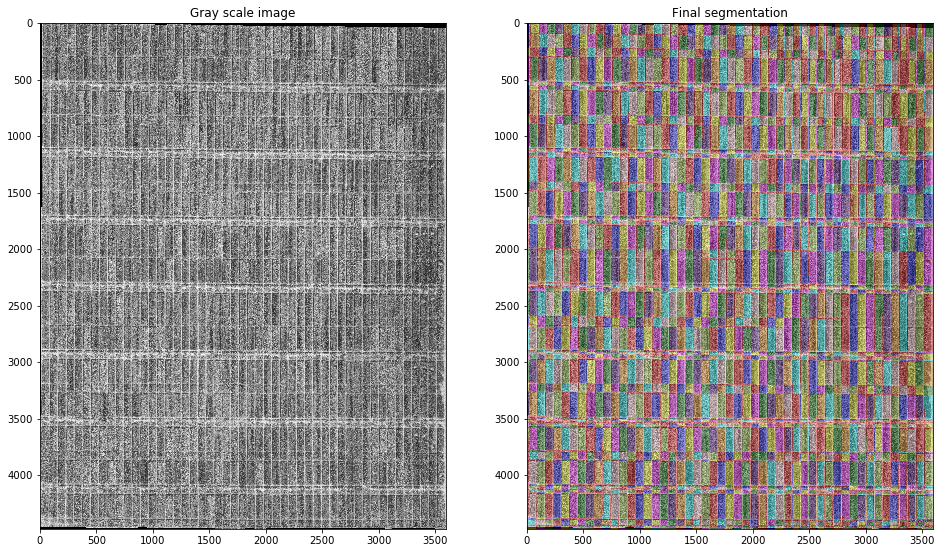

In [14]:

from skimage.measure import label
from skimage.color import label2rgb
    

selem2 = skm.square(3)

opened = skm.binary_dilation(empty, selem2)

bwDisplay = np.invert(opened)


labels = label(bwDisplay)

image_label = label2rgb(labels, image=gray)

fig, axes = plt.subplots(1, 2, figsize=(16,16))

plt.title("Original image") 
axes[0].imshow(gray, cmap="gray") 
axes[0].set_title("Gray scale image") 
origin = np.array((0, gray.shape[1]))
axes[1].set_title("Final segmentation") 
axes[1].imshow(image_label) 
plt.show()


Finally, we write the raster to disk using the georeferencing information from our original input image using a utility from the geospatial_learn library. Then using the same lib polygonize the raster for GIS. Polygonize  utilities also exist in RSGIS-lib, rasterio and QGIS.  

In [15]:
from geospatial_learn.raster import array2raster, polygonize
from geospatial_learn
bwFinal = np.invert(empty) 


outRas = '/path/segout.tif'
inRas = '/path/clipped.tif'

array2raster(bwFinal, 1, inRas, outRas, 1)

polygonize(outRas, outShp, outField='DN',  mask = True, band = 1)

#### Canny edge alternatives
Alternatively we can use canny edge detection, which will result in something similar, without having to create templates etc.

Experimenting with parameters is a good idea to understand their effect on the underlying imagery. 
For instance, altering the sigma parameter for canny edge detection is a good place to start. 

Before running on a file, try this interactive cell until you get a sensible looking edge map to detect lines from.

See below for an explanation of parameters.
https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html

In a nutshell:

- sigma = defines the size of the stdv (unitless) that defines the gaussian enevlope

These concern hysterisis thresholding - a familiar concept in image processing but just in case....
- high_threshold = the minimum (confusingly!) gradient level threshold that defines edges 
- low_threshold = gradient values of this threshold will be used if attached to edges detected using the high threshold value

Often the smoothing part is enough to get 'meaningful' results, but to fine tune may require hysterisis.


We will use a small image as the GUI will take too long to update and results will be hard to see on a larger image. 

This is just a subset of the top corner of the image. 

Apply what you think may work! Eliminating interior noise will be near impossible, but provided the most continous edges are plot divisions the results should be reasonable when detecting lines in the next step. 

In [16]:
testIm = io.imread('clipped.tif', as_gray=True)
testIm = exposure.rescale_intensity(testIm, out_range=np.uint8)

def icanny(*args, **kwargs): #...do it...haha
    
    
    edge = canny(testIm, *args, **kwargs)
    plt.figure(figsize=(30,20))


    plt.imshow(edge)
    plt.show()
        
from ipywidgets import widgets

cTester = widgets.interact(icanny,
                              sigma=widgets.IntSlider(min=0, max=50, step=1, continuous_update=False),
                              low_threshold=widgets.IntSlider(min=0, max=255, step=1, continuous_update=False),
                              high_threshold=widgets.IntSlider(min=0, max=255, step=1, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='sigma', max=50.0, step=1.0)…

## Part 2

### Outputs and attributes

Using gdal/ogr and geospatial-learn we will polygonise then attribute the segments using the underlying image properties. 

This requires the input of a few functions.

**If you have not executed the quick functions in the cell above uncomment the polygonise bits - otherwise skip through**


### Attributes

### RGB

Now to assign pixel-based attributes to every crop plot. Ideally, multispectral imagery would be used, but we only have RGB.

For this we use a function that calculates RGB indicies to aid in the indication of crop phenology.

Google will yield countless results on these - here is a paper example.

https://www.google.com/search?client=ubuntu&channel=fs&q=rgb+indices&ie=utf-8&oe=utf-8

The indices calculated are:

- ExG 
- ExR
- ExGR 
- CIVE 
- NDI
- RGBVI
- VARI
- ARI
- RGBI
- GLI
- TGL

In [ ]:
from geospatial_learn.shape import zonal_stats, texture_stats, shape_props, zonal_rgb_idx

zonal_rgb_idx(vector_path2, inRas)

Through QGIS, the attributes can be colour mapped to display potential patterns. 

### Harlick Texture

The following commands write gray level co-occurrence matrix-based texture statistics based on an angle and offset (or distance in pixels) from each pixel. In this case the default offset of 2 with the horizontally adjacent pixel. 

<img src="http://wiki.awf.forst.uni-goettingen.de/wiki/images/thumb/a/a8/Texture.png/500px-Texture.png" style="height:200px">

In [5]:
bandnames = ['r', 'g', 'b']
for bnd,name in enumerate(bandnames):
    texture_stats(outPoly, droneRas,  bnd+1,   gprop='contrast',
                  offset=2,angle=0  write_stat=True)

100%|██████████| 1954/1954 [00:02<00:00, 831.66it/s]


In [6]:
for bnd,name in enumerate(bandnames):
    texture_stats(outPoly, droneRas,  bnd+1,  gprop="energy", 
                  offset=2,angle=0  write_stat=True)

100%|██████████| 1954/1954 [00:02<00:00, 767.07it/s]


### Zonal stats

Here stats from the constituent pixels of each segment are calculated which may give us a proxy indication of health/phenology

In [ ]:
zonal_rgb_idx(outShp, 'clipped.tif')

You should end up with a shapefile containing all the attributes mentioned looking similar to that below and be able to display them as below here, in QGIS with NDI displayed per plot as a colourmap. 

From this we can see how the spatial pattern spectral characteristics could be a proxy indication of vegetation vigour - which is fairly typical of UAS use in agi-management and monitoring. 

<img src="Figures/Crops.png" style="height:500px">

## RSGISlib methods

At this point it is worth noting that the attribution of segments can be done via raster attribute tables, which is often more appropriate on a larger scale (country wide datasets). RSGISlib can be used for this purpose and further analysis could be performed to this end via this lib. A training manual has been included on this library (see the shared drive folder) which provides all the procedures necessary to replicate this type of workflow.  
